# Task 1 (Supervised Learning) - Predicting Adoption and Adoption Speed

In this task you should target 3 classification tasks:
1. **Predicting  Adoption (binary classification task)**: create a new target from AdoptionSpeed that is 1 if AdoptionSpeed <> 4 and 0 otherwise.
2. **Predicting AdoptionSpeed (multiclass classification)**: in this task you should you the original target AdoptionSpeed, whose values are in the set {0, 1, 2, 3 , 4} (5 classes). This is a very difficult problem. You might also want to consider 3 classes (for instance {0-1, 2-3, 4}, or other sets that make sense). 
3. **Train specialized models for cats and dogs**: train with cat/dog instances and check whether the classification performance changes when Predicting Adoption and Predicting AdoptionSpeed.

## Intro

**You should:**

* Choose **one classifier in each category**: Tree models, Rule models, Linear models, Distance-based models, and Probabilistic models.
* Use cross-validation to evaluate the results. 
* Present and discuss the results for different evaluation measures, present confusion matrices. Remember that not only overall results are important. Check what happens when learning to predict each class.
* Describe the parameters used for each classifier and how their choice impacted or not the results.
* Choose the best classifier and fundament you choice.
* **Discuss critically your choices and the results!**

We have only categorical data, but most of it is binary so we need to find the best models, classifing this type of data. Although it's clear that since we transformed our data in mostly binary features, we will have a much better performance with the binary target, then with the multiclass classification problem.

Models to try:

* LogitRegression (Can be used in multiclass classification, combining multiple regression functions.)
  > Coeficient selection `l1-penalized`, solver `SAGA`
* SVM with Kernel
  > HyperParameter Selection - randomized search
* Random Forests
  > HyperParameter Selection - randomized search
* KNeighbors
* Categorical Naive Bayes

Feature Selection:

* RFE with with CV / metric - accuracy
* LassoCV with CV / metric - AIC & BIC

For feature selection we ended up deciding on using only `RFE`, since it is a more common aproach, and we have finite computational power. Combining feature and hyper parameter selection is a very expensive computacional task.

The Lasso method, would explore interesting metrics like the AIC and BIC metrics for measuring the information in a model.

Performance Analysis :

* Precision & Recall
* Confusion Matrix

This methods were only explored in the binary classification problem.

* Test Error vs Train Error
* ROC for every fold in CV
* Learning Curves

## Loading Datasets

In [1]:
# Load data
import pandas as pd

Bl = pd.read_csv("Balanced_Dataset.csv", index_col=0)
Bn = pd.read_csv('Binary_Dataset.csv', index_col=0)
Bin = pd.read_csv('Binary_Imbalanced_Dataset.csv', index_col=0)

In [2]:
Bl.head()

,Type,Gender,FurLength,agecat,breedcat,namecat,descriptcat,colorcat,colorcat2,healthcat,statecat,MaturitySizecat,Photocat,quantitycat,paidcat,Target
0,2,1,1,2,0,0,0,1,1,0,1,0,1,0,1,2
1,2,1,2,0,0,0,0,1,1,0,0,1,2,0,0,0
2,1,1,2,0,0,0,0,1,1,1,1,1,5,0,0,3
3,1,2,1,2,0,1,0,1,1,1,0,1,5,0,1,2
4,1,1,1,0,0,1,0,0,1,0,1,1,3,0,0,2


In [3]:
Bn.head()

,Type,Gender,FurLength,agecat,breedcat,namecat,descriptcat,colorcat,colorcat2,healthcat,statecat,MaturitySizecat,Photocat,quantitycat,paidcat,Target
0,2,1,1,2,0,0,0,1,1,0,1,0,1,0,1,1
1,2,1,2,0,0,0,0,1,1,0,0,1,2,0,0,1
2,1,1,2,0,0,0,0,1,1,1,1,1,5,0,0,1
3,1,2,1,2,0,1,0,1,1,1,0,1,5,0,1,1
4,1,1,1,0,0,1,0,0,1,0,1,1,3,0,0,1


In [5]:
Bin.head()

,Type,Gender,FurLength,agecat,breedcat,namecat,descriptcat,colorcat,colorcat2,healthcat,statecat,MaturitySizecat,Photocat,quantitycat,paidcat
0,2,1,1,2,0,0,0,1,1,0,1,0,1,0,1
1,2,1,2,0,0,0,0,1,1,0,0,1,2,0,0
2,1,1,2,0,0,0,0,1,1,1,1,1,5,0,0
3,1,2,1,2,0,1,0,1,1,1,0,1,5,0,1
4,1,1,1,0,0,1,0,0,1,0,1,1,3,0,0


In [2]:
#Create Multy class target
my = Bl['Target'].values
Bl = Bl.drop(['Target'], axis=1)
#Create Binary Target
by = Bn['Target'].values
Bn = Bn.drop(['Target'], axis=1)
#Create Binary Imbalanced Target
iby = Bin['Target'].values
Bin = Bin.drop(['Target'], axis=1)

## Importing Modules and Functions

In [3]:
##Import all Modules
import sys
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from mlxtend.preprocessing import TransactionEncoder
from sklearn.svm import l1_min_c
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
## Import Functions
from Task1_functions import *

C:\Users\peped\Miniconda3\envs\AA\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## 1.1. MultiClass Classification

### 1.1.1 LogitRegression

#### 1.1.1.1 Model training

In [43]:
#Create Classifier with l1_min penality

cs = l1_min_c(Bl, my, loss='log') * np.logspace(0, 7, 16)

logit = linear_model.LogisticRegression(penalty='l1', solver='saga',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True, multi_class= 'multinomial')
# warm_start allows the model the use already computed coeficcients 
# Create the RFE object and compute a cross-validated score.
k_folds = 10
best = 0
cv=StratifiedKFold(k_folds)
for i, c in enumerate(cs):
    print (i, ' of ', len(cs))
    logit.set_params(C=c)
    rfecv_logit = RFECV(estimator=logit, step=1, cv=cv,
            scoring='accuracy', n_jobs = k_folds)
    rfecv_logit.fit(Bl, my)
    if max(rfecv_logit.grid_scores_) > best:
        Brfecv_logit = rfecv_logit
print(len(cs),' of ', len(cs),' : Finished')

0  of  16
1  of  16
2  of  16
3  of  16
4  of  16
5  of  16
6  of  16
7  of  16
8  of  16
9  of  16
10  of  16
11  of  16
12  of  16
13  of  16
14  of  16
15  of  16
16  of  16  : Finished


In [4]:
#Recreate model
logit = linear_model.LogisticRegression(C=548.5764441274891, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000000, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=1e-06,
                   verbose=0, warm_start=True)


#### 1.1.1.2 Model Parameters

In [44]:
print("Feature's Ranking \n")
for ix, cols in enumerate(Bl.columns):
    print(cols, ': ', Brfecv_logit.ranking_[ix])

Feature's Ranking 

Type :  1
Gender :  1
FurLength :  1
agecat :  1
breedcat :  1
namecat :  1
descriptcat :  1
colorcat :  1
colorcat2 :  1
healthcat :  1
statecat :  1
MaturitySizecat :  1
Photocat :  1
quantitycat :  1
paidcat :  1


Optimal number of features : 15


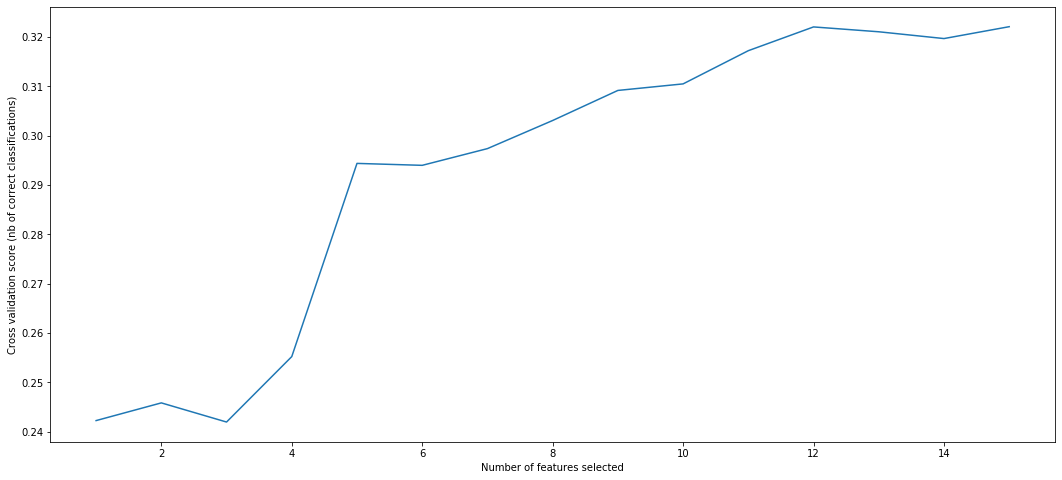

In [45]:
print("Optimal number of features : %d" % rfecv_logit.n_features_)
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(18, 8));
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(Brfecv_logit.grid_scores_) + 1), Brfecv_logit.grid_scores_)
plt.show()

In this case we see that all features were selected, but between using twelve and 15 features we don't see a big improvement on the score.

If we were running this function again we could increase the step number to allow the RFE to eliminate must of the weak features early, and this way create simplier model.


In [67]:
#get used features
#co_ = []
#for ix, cols in enumerate(Bl.columns):
#    if Brfecv_logit.ranking_[ix] == 1:
#        co_.append(cols)
#Logx = Bl[co_]
#print('Selected Features: \n', Logx.columns)
#Get Params
print('Param Selected: ', Brfecv_logit.estimator_.C)

Param Selected:  548.5764441274891


#### 1.1.1.3 Model Metrics

In [5]:
#Confusion Matrix
plt, metrics= model_metrics(Bl, my, logit, [1,2,3,4,5])
plt.show()
print(metrics)

KeyboardInterrupt: 

#### Model Remarks

We spent a lot of time training this model, so it could serve has a pipeline, for other models.

But in reality this iterative search for the best coeficient was not worth it, since this classifier simply can't classify this multi-class target, and the model didn't improve much by the search. 

Nevertheless it was good to test our pipeline and see there it's working. From now on will probably only do this type of extensive search in models that show promise.

### 1.1.2 SVM

For the support vector machine classifier, we decided to try the polynomial kernel, and the Gaussian kernel. 

Since we want our model to be able to create now linear decision boundaries, and to be able to classify a multi-class target, which excludes a sigmoid kernel. The later can only classify well binary targets, and it might be considered as a proxy to a neural network.

Let's start with a basic training of the kernels to see what the classifier is able to do. Have in mind that this is a very difficult problem to solve, and we will only use random parameters, so we are not excepting great results.

We start with the Polynomial kernel

#### 1.1.2.1 Basic Classifier Testing

<Figure size 1296x576 with 0 Axes>

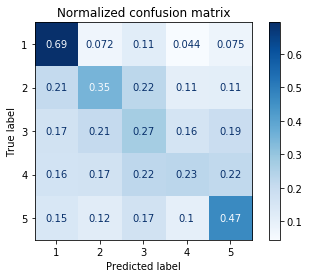

              precision    recall  f1-score   support

           0       0.52      0.69      0.60      1045
           1       0.38      0.35      0.36       956
           2       0.27      0.27      0.27       962
           3       0.35      0.23      0.28       954
           4       0.46      0.47      0.46      1019

    accuracy                           0.41      4936
   macro avg       0.39      0.40      0.39      4936
weighted avg       0.40      0.41      0.40      4936



In [18]:
#Create SVM
svclassifier = SVC(kernel='poly', degree=5, C=1)
#Create Metrics
plt, metrics= model_metrics(Bl, my, svclassifier, [1,2,3,4,5])
plt.show()
print(metrics)

It was able to classify the 0 speed category pretty well, although the general result was bad. Let's now see the Gaussian Kernel.

<Figure size 1296x576 with 0 Axes>

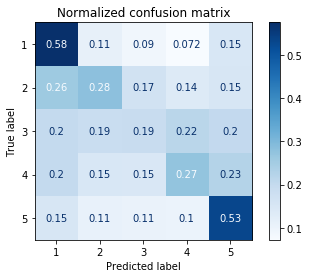

              precision    recall  f1-score   support

           0       0.43      0.58      0.49      1079
           1       0.34      0.28      0.31      1024
           2       0.26      0.19      0.22       970
           3       0.33      0.27      0.30       976
           4       0.43      0.53      0.47      1036

    accuracy                           0.38      5085
   macro avg       0.36      0.37      0.36      5085
weighted avg       0.36      0.38      0.36      5085



In [6]:
svclassifier = SVC(kernel='rbf', C=1)
plt, metrics= model_metrics(Bl, my, svclassifier, [1,2,3,4,5])
plt.show()
print(metrics)

This kernel get's worst results them the previous, they both seem to be better at classification in the extreme cases.

#### 1.1.2.2 One Vs Rest Classifier Methodology

(Explain Methodology and why it's useful)

<Figure size 1296x576 with 0 Axes>

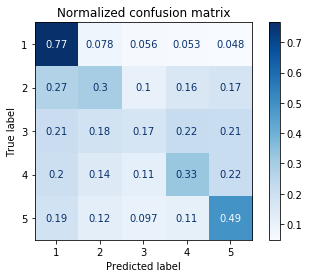

              precision    recall  f1-score   support

           0       0.49      0.77      0.59      1079
           1       0.37      0.30      0.33      1024
           2       0.30      0.17      0.22       970
           3       0.37      0.33      0.35       976
           4       0.44      0.49      0.47      1036

    accuracy                           0.42      5085
   macro avg       0.39      0.41      0.39      5085
weighted avg       0.40      0.42      0.40      5085



In [7]:
svclassifier = OneVsRestClassifier(SVC(kernel='poly', degree=5, C=1))
plt, metrics= model_metrics(Bl, my, svclassifier, [1,2,3,4,5])
plt.show()
print(metrics)

Obtains slightly better results, but needs 5times the computacion time.

#### 1.1.2.3 Feature Selection

Since polynomial svm don't give information about features importance recursive methods like `RFE`cannot be applied, so we use our previously defined general feature selection. This function through vif scores and feature importance methods is able to select the features that are more likely to give new information to the classifier.

In [4]:
#Select Features
X = feature_selector(Bl, my)
X.shape[1]

dropping 'Type' at index: 0
dropping 'Gender' at index: 0
dropping 'FurLength' at index: 0
Remaining variables:
Index(['agecat', 'breedcat', 'namecat', 'descriptcat', 'colorcat', 'colorcat2',
       'healthcat', 'statecat', 'MaturitySizecat', 'Photocat', 'quantitycat',
       'paidcat'],
      dtype='object')


3

Since only 3 features were selected we will have to change our degree, we cannot fit a 5 degree polynomial function on only 3 features. With such low feature number fitting a kernel will not ensure better results so let's try using the linear SVM.

<Figure size 1296x576 with 0 Axes>

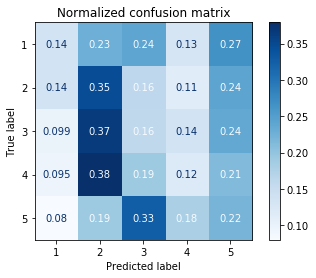

              precision    recall  f1-score   support

           0       0.26      0.14      0.18      1079
           1       0.23      0.35      0.28      1024
           2       0.14      0.16      0.15       970
           3       0.17      0.12      0.14       976
           4       0.19      0.22      0.20      1036

    accuracy                           0.20      5085
   macro avg       0.20      0.20      0.19      5085
weighted avg       0.20      0.20      0.19      5085



In [11]:
svclassifier = OneVsRestClassifier(SVC(kernel='linear', C=1))
plt, metrics= model_metrics(X, my, svclassifier, [1,2,3,4,5])
plt.show()
print(metrics)

We obtain worse results, so we will use all features.

#### 1.1.2.4 Hyper-Parameter Selection

Let's now find a good set of hyper parameters trough a random search, since is much less computationally expensive them
a grid search and there are evidence that the results will not differ much. Cite

This computation will take about 5 h, it will test 20 sets of parameters from discrete parameters distributions, with a 10 k-fold cross validation on every model, and for every model it will use one vs rest methodology, since we've seen that it obtains best results, therefore creating 5 sub-models.

Since it's a very heavy computation we will not actually run it, because we have no access to any server. But if we were doing this for real this was the correct way.

In [ ]:
#Hyper-Parameter Search
#svc_param_selection(Bl, my, 10, 20)

#### Model Remarks

We were not expecting to obtain a great deal of performance from the linear models, since this is a categorical dataset. But in the polynomial SVM we obtained a not so bad performance given the number of categories to classify. This performance could probably be improved by the previously discussed algorithm.

After considering the computation time for hyper-parameters, feature selection, and other methods we consider that could improve the performance of the models we are training decided that from now on we will only use basic approach to training. 

This will allow us to see more models and different approaches to multi-class classifier training. And since this is not a work for publication the slight improve in model performance isn't work the time spent training this models in this more complex manner.

We might open an exception for a particularly promising model.

### 1.1.3 Random Forests

#### 1.1.3.1 Basic Training

<Figure size 1296x576 with 0 Axes>

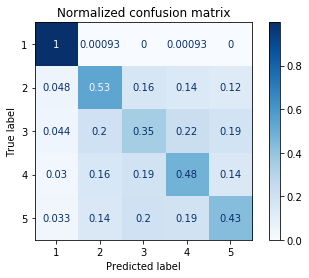

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1079
           1       0.52      0.53      0.53      1024
           2       0.38      0.35      0.36       970
           3       0.46      0.48      0.47       976
           4       0.50      0.43      0.46      1036

    accuracy                           0.57      5085
   macro avg       0.55      0.56      0.55      5085
weighted avg       0.55      0.57      0.56      5085



In [19]:
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
#Create Metrics
plt, metrics= model_metrics(Bl, my, clf, [1,2,3,4,5])
plt.show()
print(metrics)

We get very good results, our classifier is not over-fitting any class, and very good at classifying class 0, with a perfect recall and a 90% precision.

This was achived due to the use of `tommek links` to perform under-sampling, this methodology allows us to clearly separate the minority class by having all majority class data points near the minority class removed.

#### 1.1.3.2 Feature Selection

Let's now apply `RFE` to see if we can improve our classifier's performance.

In [22]:
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
rfecv_ET = RFECV(estimator=clf, step=5, cv=10,
            scoring='accuracy', n_jobs = 10)
rfecv_ET.fit(Bl, my)

RFECV(cv=10,
      estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=100, n_jobs=None,
                                     oob_score=False, random_state=0, verbose=0,
                                     warm_start=False),
      min_features_to_select=1, n_jobs=10, scoring='accuracy', step=5,
      verbose=0)

Optimal number of features : 15


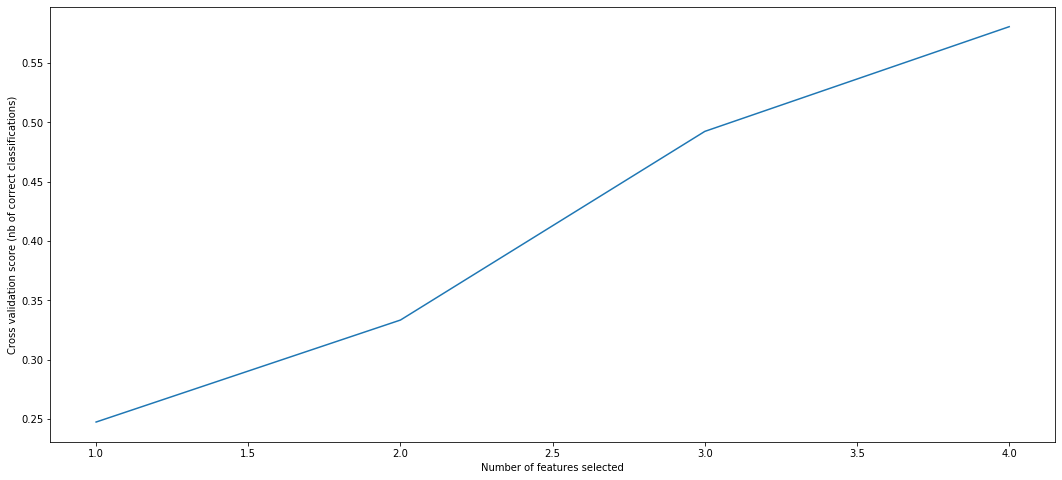

In [23]:
print("Optimal number of features : %d" % rfecv_ET.n_features_)
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(18, 8));
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_ET.grid_scores_) + 1), rfecv_ET.grid_scores_)
plt.show()

We used a bigger step in the `RFE` function so that it can earlier eliminate the not important features. But we see that the best result we obtain is using all the features.

#### 1.1.3.2 Hyper-Parameter Selection

Since this is our best model yet, and the decision tree classifier is a fast model to train, cause in reality is only fitting a small number of features, we will apply a bit of hyper-parameter selection.

This type of classifier has many hyper-parameters so will select some to check.

We will do a randomized search, with a low number of iteration (in reality this number should be higher)

In [7]:
clf = ExtraTreesClassifier()
model, improvement = et_Srandom(clf, Bl, my, 0.57, 100, 3)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.7min finished


In [24]:
print('Improvement of {:0.2f}%.'.format(improvement))
model.best_estimator_

Improvement of 0.39%.


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=40, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=5,
                     min_weight_fraction_leaf=0.0, n_estimators=1366,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [26]:
print('Performance: ', round((0.57 * 1.0039), 2))

Performance:  0.57


0.5722082903083051

We had a 0.4% increase in our performance it's not much, but since this problem is so complex it's expected.

If we wanted to improve performance even further we could shorten our grid based on this results and do a grid search.

In [29]:
final_model = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=40, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=5,
                     min_weight_fraction_leaf=0.0, n_estimators=1366,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
final_model

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=40, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=5,
                     min_weight_fraction_leaf=0.0, n_estimators=1366,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

### 1.1.4 K-neighbors

<Figure size 1296x576 with 0 Axes>

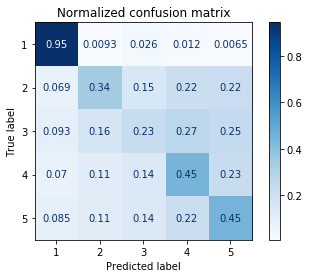

              precision    recall  f1-score   support

           0       0.76      0.95      0.84      1079
           1       0.47      0.34      0.40      1024
           2       0.33      0.23      0.27       970
           3       0.38      0.45      0.41       976
           4       0.40      0.45      0.43      1036

    accuracy                           0.49      5085
   macro avg       0.47      0.48      0.47      5085
weighted avg       0.47      0.49      0.48      5085



In [40]:
from sklearn.neighbors import KNeighborsClassifier
clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3))
plt, metrics= model_metrics(Bl, my, clf, [1,2,3,4,5])
plt.show()
print(metrics)

### 1.1.5 Categorical Naive Bayes

<Figure size 1296x576 with 0 Axes>

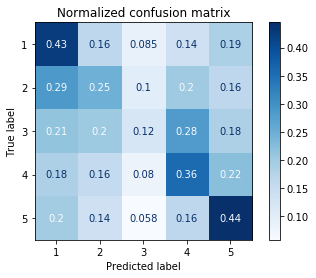

              precision    recall  f1-score   support

           0       0.34      0.43      0.38      1079
           1       0.28      0.25      0.26      1024
           2       0.26      0.12      0.16       970
           3       0.30      0.36      0.33       976
           4       0.38      0.44      0.41      1036

    accuracy                           0.32      5085
   macro avg       0.31      0.32      0.31      5085
weighted avg       0.31      0.32      0.31      5085



In [41]:
from sklearn.naive_bayes import CategoricalNB
clf = OneVsRestClassifier(CategoricalNB())
plt, metrics= model_metrics(Bl, my, clf, [1,2,3,4,5])
plt.show()
print(metrics)

This classifier performs really poorly so any improvement on his performance would not be significative. This way we decided not to do further analysis on it. 

### 1.1.6 Rule Based

In [86]:
Bl['Target'] = my
from Orange.data import Domain, DiscreteVariable, Table, ContinuousVariable
domain = Domain([DiscreteVariable.make(name='Type', values=['1', '2']),
                 DiscreteVariable.make(name='Gender', values=['1', '2', '3']),
                 DiscreteVariable.make(name='FurLength', values=['1', '2']),
                 DiscreteVariable.make(name='agecat', values=['0','1', '2', '3','4']),
                 DiscreteVariable.make(name='breedcat', values=['0', '1']),
                 DiscreteVariable.make(name='namecat', values=['0', '1']),
                 DiscreteVariable.make(name='descriptcat', values=['0', '1']),
                 DiscreteVariable.make(name='colorcat', values=['0','1', '2']),
                 DiscreteVariable.make(name='colorcat2', values=['0', '1']),
                 DiscreteVariable.make(name='healthcat', values=['0', '1']),
                 DiscreteVariable.make(name='statecat', values=['0', '1']),
                 DiscreteVariable.make(name='MaturitySizecat', values=['0', '1']),
                 DiscreteVariable.make(name='Photocat', values=['0','1', '2', '3','4', '5']),
                 DiscreteVariable.make(name='quantitycat', values=['0', '1']),
                 DiscreteVariable.make(name='paidcat', values=['0', '1'])],
                 DiscreteVariable(name='Target', values=['0','1', '2', '3','4']))
data = Table.from_numpy(domain,Bl)
data.domain

[Type, Gender, FurLength, agecat, breedcat, namecat, descriptcat, colorcat, colorcat2, healthcat, statecat, MaturitySizecat, Photocat, quantitycat, paidcat | Target]

In [96]:
learner = Orange.classification.CN2UnorderedLearner()

# consider up to 10 solution streams at one time
learner.rule_finder.search_algorithm.beam_width = 10

# continuous value space is constrained to reduce computation time
learner.rule_finder.search_strategy.constrain_continuous = True

# found rules must cover at least 15 examples
learner.rule_finder.general_validator.min_covered_examples = 15

# found rules may combine at most 2 selectors (conditions)
learner.rule_finder.general_validator.max_rule_length = 2

res = Orange.evaluation.CrossValidation(data, [learner], k=5)

C:\Users\peped\Miniconda3\envs\AA\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: calling Validation's constructor with data and learners is deprecated;
construct an instance and call it
  from ipykernel import kernelapp as app


TypeError: __init__() got an unexpected keyword argument 'pos_label'

In [97]:
#Don't know how to get scores for multi-class problem
CA = Orange.evaluation.CA(res)
F1 = Orange.evaluation.F1(res)

print('Accuracy: ', CA)
print('F1: ', F1)

TypeError: compute_score() got an unexpected keyword argument 'pos_label'

In [85]:
Bl = Bl.drop(['Target'], axis=1)

### 1.1.7 Voting Classifier 

## 1.2 Binary Classification

### 1.2.1 LogitRegression

### 1.2.2 SVM

Sigmoid Kernel

### 1.2.3 Random Forests

<Figure size 1296x576 with 0 Axes>

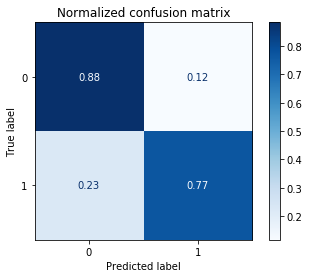

              precision    recall  f1-score   support

           0       0.79      0.88      0.84      2669
           1       0.87      0.77      0.82      2709

    accuracy                           0.83      5378
   macro avg       0.83      0.83      0.83      5378
weighted avg       0.83      0.83      0.83      5378



In [7]:
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
#Create Metrics
plt, metrics= model_metrics(Bn, by, clf, [0,1])
plt.show()
print(metrics)

### 1.2.4 K-neighbors

<Figure size 1296x576 with 0 Axes>

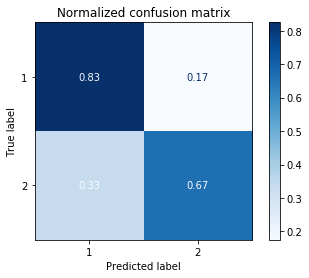

              precision    recall  f1-score   support

           0       0.71      0.83      0.76      2669
           1       0.79      0.67      0.72      2709

    accuracy                           0.74      5378
   macro avg       0.75      0.75      0.74      5378
weighted avg       0.75      0.74      0.74      5378



In [41]:
X_train, X_test, y_train, y_test = train_test_split(Bn, by, random_state=0)
from sklearn.neighbors import KNeighborsClassifier
clf = (KNeighborsClassifier(n_neighbors=3))
clf.fit(X_train, y_train)
plt, metrics= model_metrics(X_test,y_test, clf, [1,2,3,4,5])
plt.show()
print(metrics)

### 1.2.5 Rule Based

In [110]:
Bn['Target'] = by
from Orange.data import Domain, DiscreteVariable, Table, ContinuousVariable
domain = Domain([DiscreteVariable.make(name='Type', values=['1', '2']),
                 DiscreteVariable.make(name='Gender', values=['1', '2', '3']),
                 DiscreteVariable.make(name='FurLength', values=['1', '2']),
                 DiscreteVariable.make(name='agecat', values=['0','1', '2', '3','4']),
                 DiscreteVariable.make(name='breedcat', values=['0', '1']),
                 DiscreteVariable.make(name='namecat', values=['0', '1']),
                 DiscreteVariable.make(name='descriptcat', values=['0', '1']),
                 DiscreteVariable.make(name='colorcat', values=['0','1', '2']),
                 DiscreteVariable.make(name='colorcat2', values=['0', '1']),
                 DiscreteVariable.make(name='healthcat', values=['0', '1']),
                 DiscreteVariable.make(name='statecat', values=['0', '1']),
                 DiscreteVariable.make(name='MaturitySizecat', values=['0', '1']),
                 DiscreteVariable.make(name='Photocat', values=['0','1', '2', '3','4', '5']),
                 DiscreteVariable.make(name='quantitycat', values=['0', '1']),
                 DiscreteVariable.make(name='paidcat', values=['0', '1'])],
                 DiscreteVariable(name='Target', values=['0','1']))
data = Table.from_numpy(domain,Bn)
data.domain

[Type, Gender, FurLength, agecat, breedcat, namecat, descriptcat, colorcat, colorcat2, healthcat, statecat, MaturitySizecat, Photocat, quantitycat, paidcat | Target]

In [111]:
learner = Orange.classification.CN2UnorderedLearner()

# consider up to 10 solution streams at one time
learner.rule_finder.search_algorithm.beam_width = 10

# continuous value space is constrained to reduce computation time
learner.rule_finder.search_strategy.constrain_continuous = True

# found rules must cover at least 15 examples
learner.rule_finder.general_validator.min_covered_examples = 15

# found rules may combine at most 2 selectors (conditions)
learner.rule_finder.general_validator.max_rule_length = 2

res = Orange.evaluation.CrossValidation(data, [learner], k=5)

C:\Users\peped\Miniconda3\envs\AA\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: calling Validation's constructor with data and learners is deprecated;
construct an instance and call it
  from ipykernel import kernelapp as app


In [112]:
#Don't know how to get scores for multi-class problem
CA = Orange.evaluation.CA(res)
F1 = Orange.evaluation.F1(res)

print('Accuracy: ', CA)
print('F1: ', F1)

Accuracy:  [0.63]
F1:  [0.65]


In [113]:
Bn = Bn.drop(['Target'], axis=1)

We see that our classifier does not perform very well, normally we would try to see what rules are being used and how we could improve performance, but due to lack of documentation for Orange's python libraries we are not able to do it. Even get this far implicated a lot of trial and error given that the documentation is not clear on many aspects in particular loading the data into an Orange table.

### 1.2.6 Bernoulli Naive Bayes

### 1.2.7 Voting Classifier

# Test

## 1.3. Classification - Results and Discussion 

ValueError: LogisticRegression should be a binary classifer

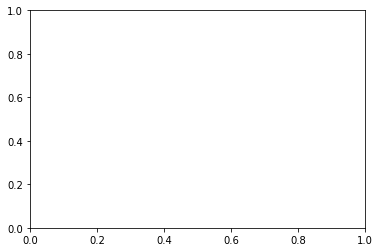

In [37]:
from scipy import interp
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
#get used features
c_del = []
for ix, cols in enumerate(Bl.columns):
    if Brfecv_logit.ranking_[ix] != 1:
        c_del.append(cols)
Logx = Bl.drop(c_del, axis=1)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

#ROC analysis

classifier = Brfecv_logit.estimator_
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(Logx, my)):
    viz = plot_roc_curve(classifier, Logx.iloc[test], my[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

#Plot ROC

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()